In [39]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcard4/creditcard.csv


In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, accuracy_score
import shap

In [41]:
# Load Dataset
df = pd.read_csv("/kaggle/input/creditcard4/creditcard.csv")
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [42]:
# Reduce dataset size (Keep all fraud cases + sample fewer non-fraud cases)
fraud_cases = df[df['Class'] == 1]
non_fraud_cases = df[df['Class'] == 0].sample(n=29500, random_state=42)
df = pd.concat([fraud_cases, non_fraud_cases]).sample(frac=1, random_state=42)

In [43]:
X = df.drop(columns=['Class'])
y = df['Class']

In [44]:
# Apply SMOTE for Class Balancing
smote = SMOTE(sampling_strategy=0.2, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [45]:
# Feature Scaling
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)

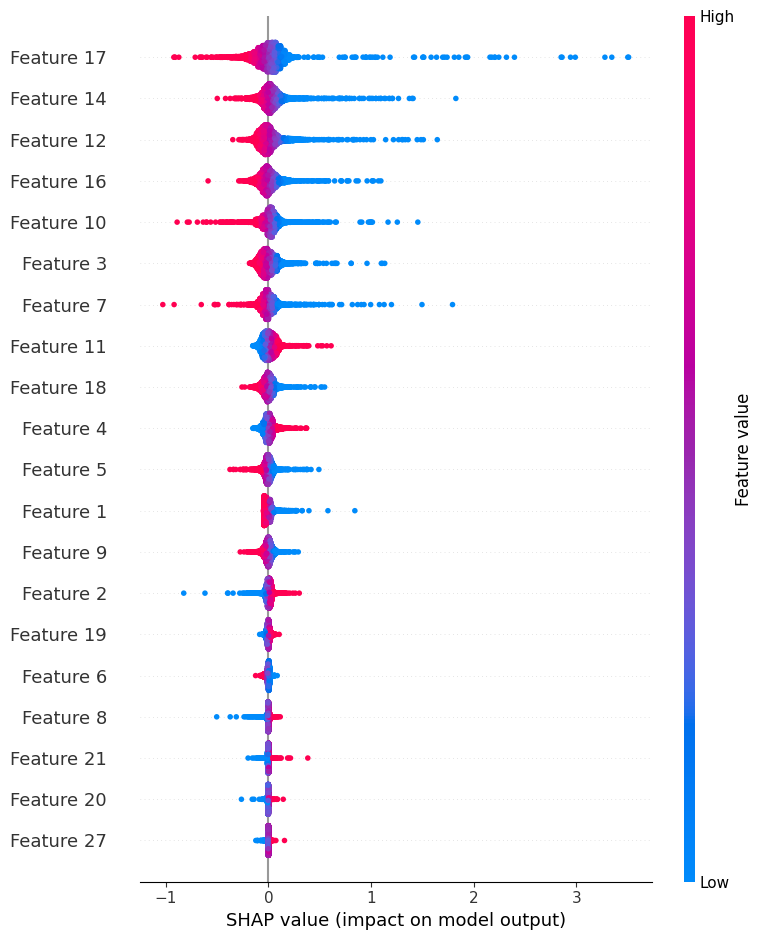

In [46]:
# Feature Selection using SHAP (on a subset to save memory)
subset_X = X_resampled[:5000]
subset_y = y_resampled[:5000]
svm_model = SVC(kernel='linear', probability=True).fit(subset_X, subset_y)
explainer = shap.Explainer(svm_model, subset_X)
shap_values = explainer(subset_X)
shap.summary_plot(shap_values, subset_X)

# Dimensionality Reduction (PCA with fewer components)
X_pca = PCA(n_components=5).fit_transform(X_resampled)

In [47]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [48]:
# Quantum-Inspired Kernels (Optimized)
def polynomial_quantum_kernel(X1, X2, degree=3, batch_size=1000):
    """Compute Polynomial Quantum Kernel in Batches to Save Memory"""
    num_samples = X1.shape[0]
    kernel_matrix = np.zeros((num_samples, X2.shape[0]))

    for i in range(0, num_samples, batch_size):
        end = i + batch_size
        kernel_matrix[i:end] = (1 + np.dot(X1[i:end], X2.T)) ** degree
    
    return kernel_matrix

In [49]:
# Train Traditional SVM
svm_traditional = SVC(kernel='rbf').fit(X_train, y_train)
y_pred_svm = svm_traditional.predict(X_test)

In [50]:
# Train Quantum-Inspired Kernel SVM
svm_qik = SVC(kernel='precomputed')
K_train = polynomial_quantum_kernel(X_train, X_train)
K_test = polynomial_quantum_kernel(X_test, X_train)
svm_qik.fit(K_train, y_train)
y_pred_qik = svm_qik.predict(K_test)

In [51]:
# Confusion Matrices
cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_qik = confusion_matrix(y_test, y_pred_qik)


In [52]:
# ROC-AUC and Precision-Recall Curve
svm_probs = svm_traditional.decision_function(X_test)
qik_probs = svm_qik.decision_function(K_test)

In [53]:
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_probs)
fpr_qik, tpr_qik, _ = roc_curve(y_test, qik_probs)

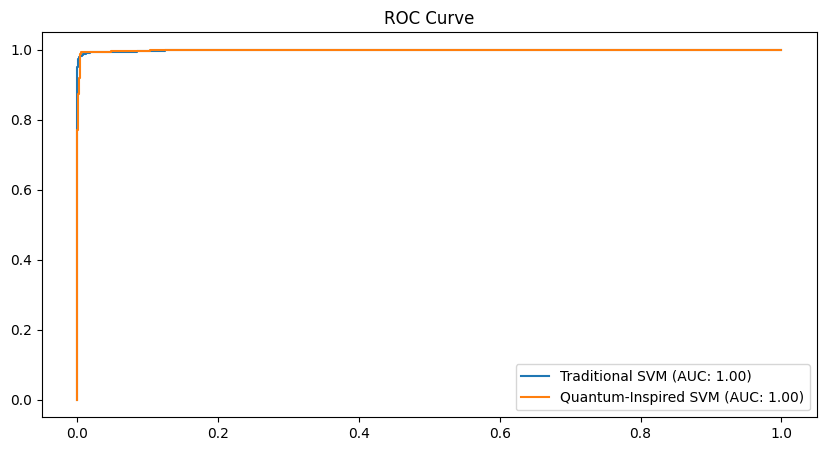

In [54]:
plt.figure(figsize=(10,5))
plt.plot(fpr_svm, tpr_svm, label='Traditional SVM (AUC: {:.2f})'.format(auc(fpr_svm, tpr_svm)))
plt.plot(fpr_qik, tpr_qik, label='Quantum-Inspired SVM (AUC: {:.2f})'.format(auc(fpr_qik, tpr_qik)))
plt.legend()
plt.title('ROC Curve')
plt.show()


In [57]:
# Print Classification Reports
print("Traditional SVM Report:\n", classification_report(y_test, y_pred_svm))
print(accuracy_score(y_test, y_pred_svm))
print("Quantum-Inspired SVM Report:\n", classification_report(y_test, y_pred_qik))
print(accuracy_score(y_test, y_pred_qik))

Traditional SVM Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      5882
           1       0.99      0.96      0.98      1198

    accuracy                           0.99      7080
   macro avg       0.99      0.98      0.99      7080
weighted avg       0.99      0.99      0.99      7080

0.9929378531073446
Quantum-Inspired SVM Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      5882
           1       0.97      0.99      0.98      1198

    accuracy                           0.99      7080
   macro avg       0.98      0.99      0.99      7080
weighted avg       0.99      0.99      0.99      7080

0.9936440677966102


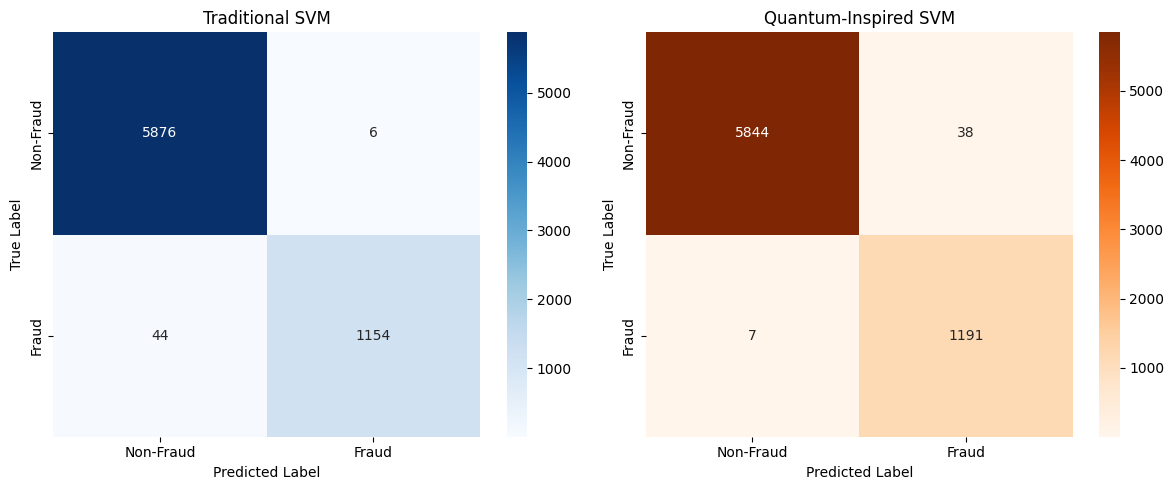

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Traditional SVM Confusion Matrix
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'], ax=axes[0])
axes[0].set_title("Traditional SVM")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# Quantum-Inspired SVM Confusion Matrix
sns.heatmap(cm_qik, annot=True, fmt='d', cmap='Oranges', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'], ax=axes[1])
axes[1].set_title("Quantum-Inspired SVM")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

# Adjust layout for better visualization
plt.tight_layout()
plt.show()


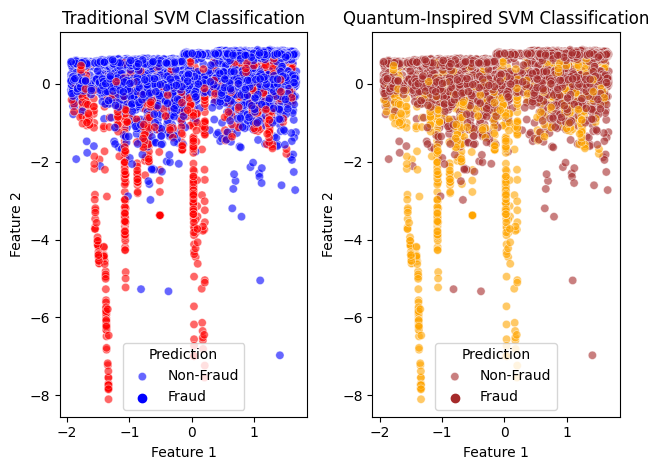

In [59]:
# Scatter Plot for Traditional SVM
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=y_pred_svm, palette={0: "blue", 1: "red"}, alpha=0.6)
plt.title("Traditional SVM Classification")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(title="Prediction", labels=["Non-Fraud", "Fraud"])

# Scatter Plot for Quantum-Inspired SVM
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=y_pred_qik, palette={0: "brown", 1: "orange"}, alpha=0.6)
plt.title("Quantum-Inspired SVM Classification")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(title="Prediction", labels=["Non-Fraud", "Fraud"])

plt.tight_layout()
plt.show()